# Distilling BERT models

In [1]:
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer

pre_merged_anime = pd.read_csv('../data/pre_merged_anime.csv')
print(pre_merged_anime.shape)
pre_merged_anime.head(2)

(16206, 19)


,MAL_ID,Name,Score,Genres,English name,Type,Episodes,Premiered,Producers,Studios,Source,Duration,Rating,Ranked,Members,Favorites,Completed,On-Hold,synopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,TV,26,Spring 1998,Bandai Visual,Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,1251960,61971,718161,71513,"In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,Movie,1,Unknown,"Sunrise, Bandai Visual",Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,273145,1174,208333,1935,"other day, another bounty—such is the life of ..."


In [2]:
import re
import string

def clean_text(text):
    # Remove non-printable characters
    text = ''.join(filter(lambda x: x in string.printable, text))
    # Replace multiple whitespace characters with a single space
    text = re.sub(r'\s{2,}', ' ', text).strip()
    return text.strip()

# WITH NO GENRES
def get_anime_description(anime_row):
    """
    Generates a custom description for an anime title based on various features from the input data.

    :param anime_row: A row from the MyAnimeList dataset containing relevant anime information.
    :return: A formatted string containing a custom description of the anime.
    """

    # Determine the type of anime (TV show or other)
    anime_type = "TV Show" if anime_row["Type"] == "TV" else anime_row["Type"]

    # Create a formatted description using the relevant features from the input data
    description = (
        f"{anime_row['Name']} is a {anime_type}.\n"
        f"Synopsis: {anime_row['synopsis']}\n"
        f"It was produced by {anime_row['Producers']} and it is from {anime_row['Studios']} Studio.\n"
        f"Its source is {anime_row['Source']}.\n"
        f"It premiered in {anime_row['Premiered']}."
    )

    return clean_text(description)


In [3]:
print(clean_text(get_anime_description(pre_merged_anime.iloc[0])))

Cowboy Bebop is a TV Show.
Synopsis: In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as "Cowboys." The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travelsEin, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wongthe crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Be

In [4]:
# Create a new column in our merged anime dataframe for our new descriptions
pre_merged_anime['generated_description'] = pre_merged_anime.apply(get_anime_description, axis=1)


In [5]:
from functools import reduce

all_genres = list(reduce(lambda y, z: y + z, pre_merged_anime['Genres'].map(lambda x: x.split(', '))))
all_genres[:3]

['Action', 'Adventure', 'Comedy']

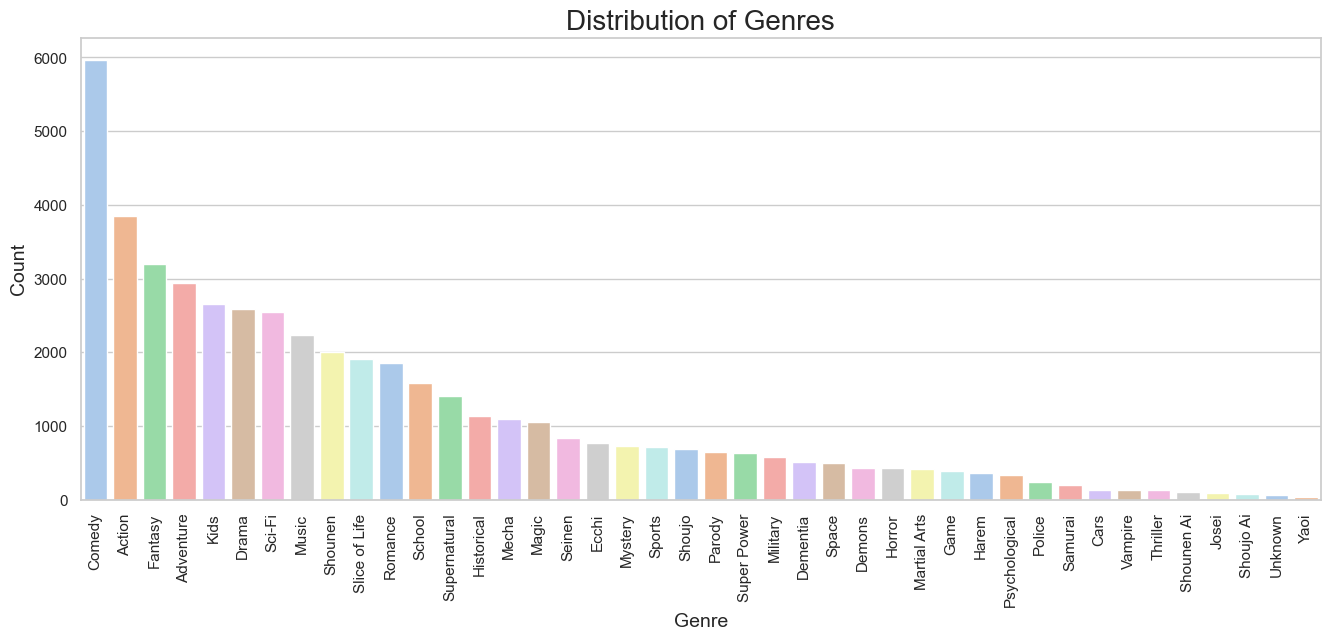

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style and context
sns.set_style('whitegrid')
sns.set_context('notebook')

# Prepare the data
genre_counts = pd.Series(all_genres).value_counts()

# Create the plot
plt.figure(figsize=(16, 6))

colors = sns.color_palette('pastel')[0:len(genre_counts)]
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette=colors)

plt.title('Distribution of Genres', fontsize=20)
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=90)

# Show and save the plot
plt.show()

In [7]:
unique_labels = sorted(list(set(reduce(lambda y, z: y + z, pre_merged_anime['Genres'].map(lambda x: x.split(', '))))))

print(len(unique_labels), unique_labels)

42 ['Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons', 'Drama', 'Ecchi', 'Fantasy', 'Game', 'Harem', 'Historical', 'Horror', 'Josei', 'Kids', 'Magic', 'Martial Arts', 'Mecha', 'Military', 'Music', 'Mystery', 'Parody', 'Police', 'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi', 'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai', 'Slice of Life', 'Space', 'Sports', 'Super Power', 'Supernatural', 'Thriller', 'Unknown', 'Vampire', 'Yaoi']


In [8]:
id2label = {idx:label for idx, label in enumerate(unique_labels)}
label2id = {label:idx for idx, label in enumerate(unique_labels)}
     

In [9]:
import numpy as np
import torch
TEACHER_MODEL = 'bert-large-uncased'

tokenizer = AutoTokenizer.from_pretrained(TEACHER_MODEL)

def preprocess_data(examples, text_col):
    one_hot_encoded_matrix = []
    text = examples[text_col]
    genres = examples["Genres"]
    for genre in genres:
        g = genre.split(', ')
        one_hot_encoded_row = [1 if label in g else 0 for label in unique_labels]
        one_hot_encoded_matrix.append(one_hot_encoded_row)

    # Convert the one_hot_encoded_matrix to a LongTensor
    one_hot_encoded_matrix = [torch.tensor(o, dtype=torch.float32) for o in one_hot_encoded_matrix]

    # Encode the text
    encoding = tokenizer(text, truncation=True, max_length=256)
    
    # Add labels
    encoding["labels"] = one_hot_encoded_matrix

    return encoding


In [10]:
from datasets import Dataset
anime_with_synopsis_dataset = Dataset.from_pandas(pre_merged_anime[['synopsis', 'Genres', 'generated_description']])

anime_with_synopsis_dataset = anime_with_synopsis_dataset.train_test_split(test_size=.2, seed=42)

In [11]:
description_encoded_dataset = anime_with_synopsis_dataset.map(
    lambda x: preprocess_data(x, 'generated_description'),
    batched=True, batch_size=128, remove_columns=['synopsis', 'Genres', 'generated_description']
)

description_encoded_dataset


Map:   0%|          | 0/12964 [00:00<?, ? examples/s]

Map:   0%|          | 0/3242 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 12964
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3242
    })
})

In [12]:
description_encoded_dataset['train'][0]

{'input_ids': [101,
  14100,
  6172,
  23289,
  2003,
  1037,
  2694,
  2265,
  1012,
  19962,
  22599,
  1024,
  5595,
  2086,
  3283,
  1010,
  3287,
  6767,
  16136,
  6386,
  2124,
  2004,
  2601,
  7545,
  2716,
  2055,
  1996,
  1000,
  2058,
  23663,
  1010,
  1000,
  1037,
  10250,
  10631,
  24826,
  2015,
  2724,
  2008,
  3908,
  2028,
  1011,
  7891,
  1997,
  1996,
  2088,
  1012,
  1999,
  1996,
  2556,
  2154,
  1010,
  1996,
  11265,
  14971,
  6313,
  3029,
  5698,
  4003,
  11014,
  1996,
  2601,
  7545,
  1005,
  2373,
  2005,
  2037,
  2035,
  2021,
  7036,
  11174,
  1012,
  5292,
  6820,
  8294,
  1010,
  1037,
  4690,
  1011,
  26974,
  3165,
  1011,
  10681,
  10563,
  1010,
  22490,
  2015,
  1996,
  2516,
  1997,
  23289,
  3040,
  1024,
  1996,
  2711,
  2040,
  15536,
  14273,
  2015,
  1996,
  2373,
  1997,
  1996,
  8987,
  23289,
  6386,
  1010,
  10471,
  5214,
  1997,
  9846,
  1996,
  2601,
  7545,
  1012,
  2174,
  1010,
  1996,
  2116,
  23289,
  638

In [13]:
# Import the necessary libraries
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, jaccard_score

# Define a function to compute several multi-label metrics
def multi_label_metrics(predictions, labels, threshold=0.5):
    # Initialize the sigmoid function which we'll use to transform our raw prediction values
    sigmoid = torch.nn.Sigmoid()
    
    # Apply sigmoid function to our predictions
    probs = sigmoid(torch.Tensor(predictions))
    
    # Create a binary prediction array based on our threshold
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    
    # Use actual labels as y_true
    y_true = labels
    
    # Compute F1 score, ROC AUC score, Accuracy, and Jaccard score
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average='micro')
    accuracy = accuracy_score(y_true, y_pred)
    jaccard = jaccard_score(y_true, y_pred, average='micro')
    
    # Package the scores into a dictionary and return it
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy,
               'jaccard': jaccard}
    return metrics

# Define a function to compute metrics for predictions
def compute_metrics(p: EvalPrediction):
    # Extract the prediction values from the EvalPrediction object
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    
    # Compute the multi-label metrics for the predictions and actual labels
    result = multi_label_metrics(predictions=preds, labels=p.label_ids)
    
    # Return the results
    return result


In [14]:
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Train with normal BERT

In [12]:
model = AutoModelForSequenceClassification.from_pretrained(
    TEACHER_MODEL,
    problem_type="multi_label_classification", 
    num_labels=len(unique_labels),
    id2label=id2label,
    label2id=label2id
)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly

In [20]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"genre-prediction-bert",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=16,
    per_device_eval_batch_size=64,
    num_train_epochs=10,
    logging_steps=50,
    load_best_model_at_end=True,
    fp16=True
)

trainer = Trainer(
    model,
    args,
    train_dataset=description_encoded_dataset["train"],
    eval_dataset=description_encoded_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.evaluate()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


wandb: Currently logged in as: profoz. Use `wandb login --relogin` to force relogin


{'eval_loss': 0.7340084314346313,
 'eval_f1': 0.10238879736408567,
 'eval_roc_auc': 0.45753649576323013,
 'eval_accuracy': 0.0,
 'eval_jaccard': 0.05395667838694274,
 'eval_runtime': 86.0092,
 'eval_samples_per_second': 37.694,
 'eval_steps_per_second': 0.302}

In [21]:
trainer.train()

C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Jaccard
0,0.210000,0.196911,0.261087,0.577813,0.056755,0.150144
1,0.172100,0.165546,0.454545,0.661204,0.121838,0.294118
2,0.147500,0.150766,0.539274,0.709597,0.144355,0.369182
3,0.130600,0.142275,0.551376,0.711728,0.156385,0.380621
4,0.116900,0.137746,0.579970,0.733529,0.166564,0.408421
5,0.103400,0.134732,0.605386,0.749923,0.184454,0.434089
6,0.093700,0.133428,0.614290,0.757610,0.190315,0.443303
8,0.086700,0.133145,0.620375,0.762284,0.192474,0.449669
8,0.080600,0.132554,0.622715,0.762406,0.201419,0.452132
9,0.077300,0.132676,0.626066,0.765166,0.200802,0.455674


C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\sinan\anaconda3\envs\DL\lib\site-packages

TrainOutput(global_step=1000, training_loss=0.1294983742237091, metrics={'train_runtime': 18498.7014, 'train_samples_per_second': 6.943, 'train_steps_per_second': 0.054, 'total_flos': 5.44381673587915e+16, 'train_loss': 0.1294983742237091, 'epoch': 9.96})

In [22]:
trainer.save_model()

# Train with Distil BERT (Task-Agnostic Distilation)

In [23]:

distil_model = AutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    problem_type="multi_label_classification", 
    num_labels=len(unique_labels),
    id2label=id2label,
    label2id=label2id
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

In [24]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"genre-prediction-distilbert",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=64,
    num_train_epochs=10,
    logging_steps=50,
    load_best_model_at_end=True,
    fp16=True
)

trainer = Trainer(
    distil_model,
    args,
    train_dataset=description_encoded_dataset["train"],
    eval_dataset=description_encoded_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.evaluate()

C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.6807233095169067,
 'eval_f1': 0.14024870679318968,
 'eval_roc_auc': 0.5349742837728174,
 'eval_accuracy': 0.0,
 'eval_jaccard': 0.07541261420571765,
 'eval_runtime': 13.3709,
 'eval_samples_per_second': 242.467,
 'eval_steps_per_second': 1.945}

In [25]:
trainer.train()

C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Jaccard
0,0.225500,0.214580,0.000000,0.500000,0.000000,0.000000
2,0.191100,0.181517,0.265005,0.578795,0.065083,0.152741
2,0.165800,0.163645,0.447409,0.659666,0.119988,0.288169
4,0.148400,0.152460,0.469803,0.667865,0.125540,0.307022
4,0.135700,0.146029,0.506707,0.686230,0.138186,0.339322
6,0.123200,0.142748,0.546603,0.714366,0.153917,0.376086
6,0.115200,0.140644,0.557181,0.719514,0.157927,0.386175
8,0.109000,0.140550,0.564871,0.725514,0.162246,0.393603
8,0.103400,0.139919,0.564481,0.724473,0.162554,0.393224
9,0.101100,0.139990,0.565733,0.724779,0.167181,0.394441


C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\sinan\anaconda3\envs\DL\lib\site-packages

TrainOutput(global_step=1000, training_loss=0.15187877035140993, metrics={'train_runtime': 2016.1971, 'train_samples_per_second': 63.699, 'train_steps_per_second': 0.496, 'total_flos': 8453222092487700.0, 'train_loss': 0.15187877035140993, 'epoch': 9.95})

# (Task-Specific Distilation)

In [15]:
from transformers import TrainingArguments, Trainer
import torch
import torch.nn as nn
import torch.nn.functional as F

# Custom TrainingArguments class to add distillation specific parameters
class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)

        # Alpha is the weight for the original student loss
        # A higher value means more focus on the student's original task
        self.alpha = alpha

        # Temperature parameter to soften probability distributions before calculating distillation loss
        # Higher value makes the distribution more uniform, carrying more information about the teacher model's outputs
        self.temperature = temperature

# Custom Trainer class to implement knowledge distillation
class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        
        # The teacher model, a pre-trained model that the student model will learn from
        self.teacher = teacher_model

        # Move the teacher model to the same device as the student model
        # This is necessary for the computations in the forward pass
        self._move_model_to_device(self.teacher, self.model.device)

        # Set teacher model to eval mode because we only want to use it for inference, not for training
        self.teacher.eval()

    def compute_loss(self, model, inputs, return_outputs=False):
        # Compute the output of the student model on the inputs
        outputs_student = model(**inputs)
        # Original loss of the student model (e.g., cross entropy for classification)
        student_loss = outputs_student.loss

        # Compute the output of the teacher model on the inputs
        # We don't need gradients for the teacher model, so we use torch.no_grad to avoid unnecessary computation
        with torch.no_grad():
            outputs_teacher = self.teacher(**inputs)

        # Check that the sizes of the student and teacher outputs match
        assert outputs_student.logits.size() == outputs_teacher.logits.size()

        # Kullback-Leibler divergence loss function, comparing the softened output distributions of the student and teacher models
        loss_function = nn.KLDivLoss(reduction="batchmean")

        # Calculate the distillation loss between the student and teacher outputs
        # We apply log_softmax to the student's outputs and softmax to the teacher's outputs before calculating the loss
        # This is due to the expectation of log probabilities for the input and probabilities for the target in nn.KLDivLoss
        
        # Note multiplying by temperature^2 is not to punish the loss like we did during reward modeling for SAWYER..
        # It is done because we divided both student and teacher logits by temperature so this operation puts the loss
        # back on the same scale as student_loss, which we are about to combine using a weighted mean
        loss_logits = (loss_function(
            F.log_softmax(outputs_student.logits / self.args.temperature, dim=-1),
            F.softmax(outputs_teacher.logits / self.args.temperature, dim=-1)) * (self.args.temperature ** 2))

        # The total loss is a weighted combination of the student's original loss and the distillation loss
        loss = self.args.alpha * student_loss + (1. - self.args.alpha) * loss_logits

        # Depending on the return_outputs parameter, return either the loss alone or the loss and the student's outputs
        return (loss, outputs_student) if return_outputs else loss


In [16]:
tokenizer = AutoTokenizer.from_pretrained(TEACHER_MODEL)

trained_model = AutoModelForSequenceClassification.from_pretrained(
    f"genre-prediction-bert", problem_type="multi_label_classification",
)


In [17]:
# define student model
student_model = AutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(unique_labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.

In [24]:
# define training args
training_args = DistillationTrainingArguments(
    output_dir='distilled-genre-prediction',
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    num_train_epochs=10,
    logging_steps=50,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=64,
    load_best_model_at_end=True,
    alpha=0.2,
    temperature=8.0,
    use_mps_device=True
#     fp16=True
    )


In [25]:
distil_trainer = DistillationTrainer(
    student_model,
    training_args,
    teacher_model=trained_model,
    train_dataset=description_encoded_dataset["train"],
    eval_dataset=description_encoded_dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


In [26]:
distil_trainer.evaluate()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Currently logged in as: profoz. Use `wandb login --relogin` to force relogin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{'eval_loss': 0.19041641056537628,
 'eval_f1': 0.12052846007112074,
 'eval_roc_auc': 0.4869344628339549,
 'eval_accuracy': 0.0,
 'eval_jaccard': 0.06412890938251804,
 'eval_runtime': 113.5274,
 'eval_samples_per_second': 28.557,
 'eval_steps_per_second': 0.449}

In [ ]:
distil_trainer.train()

/opt/homebrew/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


In [38]:
distil_trainer.train()

C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Jaccard
0,0.886300,0.630698,0.460421,0.730562,0.041024,0.299056
2,0.584000,0.415083,0.518557,0.721375,0.123072,0.350035
2,0.451300,0.333049,0.540035,0.722533,0.149599,0.369896
4,0.365900,0.294507,0.552130,0.725916,0.150524,0.381340
4,0.306600,0.284926,0.555126,0.725027,0.151450,0.384203
6,0.261700,0.270110,0.568314,0.733727,0.157310,0.396954
6,0.233000,0.272241,0.567286,0.732110,0.160703,0.395952
8,0.212700,0.266215,0.570596,0.734322,0.159161,0.399185
8,0.199100,0.265983,0.570329,0.732915,0.162554,0.398923
9,0.190700,0.262912,0.573898,0.735281,0.163479,0.402424


C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\sinan\anaconda3\envs\DL\lib\site-packages

TrainOutput(global_step=1000, training_loss=0.3958173961639404, metrics={'train_runtime': 12865.4267, 'train_samples_per_second': 9.983, 'train_steps_per_second': 0.078, 'total_flos': 8453222092487700.0, 'train_loss': 0.3958173961639404, 'epoch': 9.95})

In [52]:
distil_trainer.save_model()

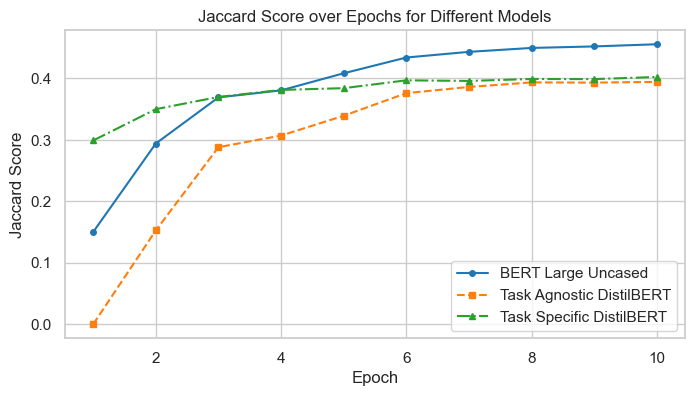

In [13]:
import matplotlib.pyplot as plt

# Assuming that your epochs start from 0 and increase by 2
epochs = range(1,11)

# Jaccard scores for each model (replace with your values)
bert_jaccard = [0.150144, 0.294118, 0.369182, 0.380621, 0.408421, 0.434089, 0.443303, 0.449669, 0.452132, 0.455674]
agnostic_distilbert_jaccard = [0.000000, 0.152741, 0.288169, 0.307022, 0.339322, 0.376086, 0.386175, 0.393603, 0.393224, 0.394441]
specific_distilbert_jaccard = [0.299056, 0.350035, 0.369896, 0.381340, 0.384203, 0.396954, 0.395952, 0.399185, 0.398923, 0.402424]

# F1 scores for BERT Large Uncased
bert_f1 = [0.261087, 0.454545, 0.539274, 0.551376, 0.579970, 0.605386, 0.614290, 0.620375, 0.622715, 0.626066]
# F1 scores for Task Agnostic DistilBERT
agnostic_distilbert_f1 = [0.000000, 0.265005, 0.447409, 0.469803, 0.506707, 0.546603, 0.557181, 0.564871, 0.564481, 0.565733]
# F1 scores for Task Specific DistilBERT
specific_distilbert_f1 = [0.460421, 0.518557, 0.540035, 0.552130, 0.555126, 0.568314, 0.567286, 0.570596, 0.570329, 0.573898]


plt.figure(figsize=(8, 4))
plt.plot(epochs, bert_jaccard, marker='o', markersize=4, linestyle='-', label='BERT Large Uncased')
plt.plot(epochs, agnostic_distilbert_jaccard, marker='s', markersize=4, linestyle='--', label='Task Agnostic DistilBERT')
plt.plot(epochs, specific_distilbert_jaccard, marker='^', markersize=4, linestyle='-.', label='Task Specific DistilBERT')

plt.xlabel('Epoch')
plt.ylabel('Jaccard Score')
plt.title('Jaccard Score over Epochs for Different Models')
plt.legend()
plt.grid(True)
plt.show()


# Using our models

In [54]:
# Our base model
trained_model = AutoModelForSequenceClassification.from_pretrained(
    f"genre-prediction-bert", problem_type="multi_label_classification",
)

# Our task specific model
task_specific_model = AutoModelForSequenceClassification.from_pretrained(
    'distilled-genre-prediction',problem_type="multi_label_classification", 
)

In [80]:
batch = data_collator(list(description_encoded_dataset['test'])[:16])

In [81]:
%timeit trained_model(**batch)

8.65 s ± 121 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [85]:
distil_batch = {k: v for k, v in batch.items() if k != 'token_type_ids'}

In [86]:
%timeit task_specific_model(**distil_batch)

1.35 s ± 17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# ^^ shows how our distilled model is over 6x faster

In [91]:
# Count the number of parameters in the trained_model
num_params_trained = sum(p.numel() for p in trained_model.parameters())
print(f'Trained Model has {num_params_trained} parameters.')

# Print the data types of the parameters in the trained_model
for p in trained_model.parameters():
    print(f'Data type of the parameter in trained_model: {p.dtype}')
    break  # We break after printing the first one assuming all parameters have the same dtype

# Count the number of parameters in the task_specific_model
num_params_task_specific = sum(p.numel() for p in task_specific_model.parameters())
print(f'Task Specific Model has {num_params_task_specific} parameters.')

# Print the data types of the parameters in the task_specific_model
for p in task_specific_model.parameters():
    print(f'Data type of the parameter in task_specific_model: {p.dtype}')
    break  # We break after printing the first one assuming all parameters have the same dtype

# Estimate the memory usage (in MB assuming parameters are stored as 32-bit floats)
memory_usage_trained = num_params_trained * 4 / (1024 ** 2)
memory_usage_task_specific = num_params_task_specific * 4 / (1024 ** 2)

print(f'Estimated memory for trained_model: {memory_usage_trained} MB')
print(f'Estimated memory for task_specific_model: {memory_usage_task_specific} MB')


Trained Model has 335184938 parameters.
Data type of the parameter in trained_model: torch.float32
Task Specific Model has 66985770 parameters.
Data type of the parameter in task_specific_model: torch.float32
Estimated memory for trained_model: 1278.6290664672852 MB
Estimated memory for task_specific_model: 255.53043365478516 MB


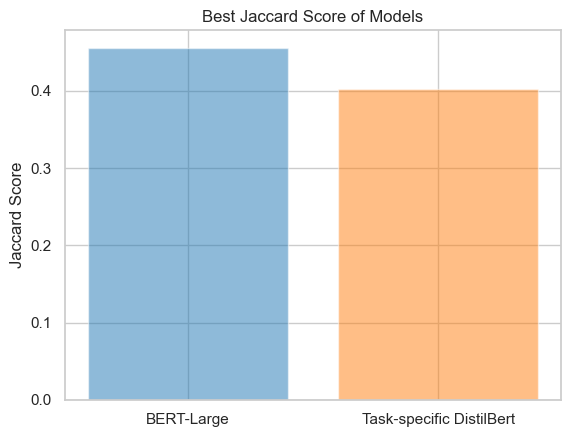

In [101]:
import matplotlib.pyplot as plt

# Model names
models = ['BERT-Large', 'Task-specific DistilBert']

# Estimated memory usage (in MB)
memory_usage = [.455674, 0.402424]

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Generate a bar plot with patterns
bars = ax.bar(models, memory_usage, align='center', alpha=0.5, color=['#1f77b4', '#ff7f0e'])

# Add labels and title
ax.set_ylabel('Jaccard Score')
ax.set_title('Best Jaccard Score of Models')

# Display the plot
plt.show()


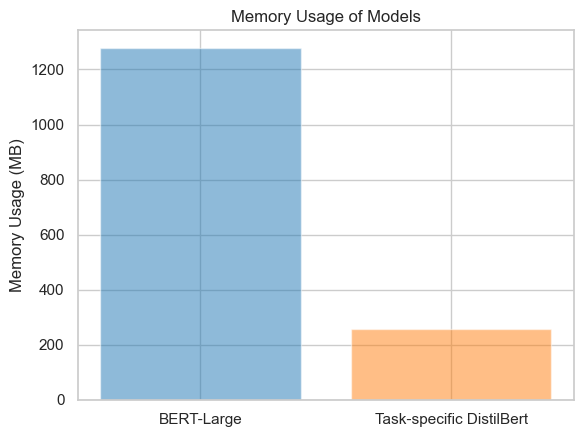

In [103]:
import matplotlib.pyplot as plt

# Model names
models = ['BERT-Large', 'Task-specific DistilBert']

# Estimated memory usage (in MB)
memory_usage = [1278.63, 255.53]

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Generate a bar plot with patterns
bars = ax.bar(models, memory_usage, align='center', alpha=0.5, color=['#1f77b4', '#ff7f0e'])

# Add labels and title
ax.set_ylabel('Memory Usage (MB)')
ax.set_title('Memory Usage of Models')

# Display the plot
plt.show()


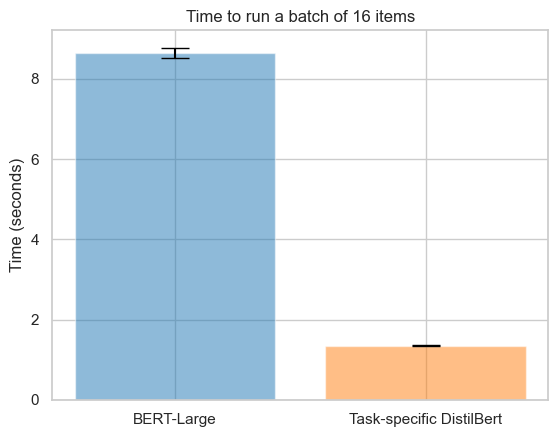

In [102]:
import matplotlib.pyplot as plt

# Model names
models = ['BERT-Large', 'Task-specific DistilBert']

# Times taken to run a batch of 16 items (in seconds)
times = [8.65, 1.35]

# Standard deviations
std_devs = [0.121, 0.017]

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Generate a bar plot
ax.bar(models, times, yerr=std_devs, align='center', alpha=0.5, ecolor='black', capsize=10,  color=['#1f77b4', '#ff7f0e'])

# Add labels and title
ax.set_ylabel('Time (seconds)')
ax.set_title('Time to run a batch of 16 items')

# Display the plot
plt.show()
